<a href="https://colab.research.google.com/github/varun2001-vit/Jupyter/blob/main/store_sales_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1-Libraries and Data Loading

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from scipy import stats
from scipy.special import boxcox1p

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings("ignore") # ignoring annoying warnings
!pip install pandasql
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26784 sha256=e0ae40a317eedd92bea12724092dd2fc25d8d8eb68df7348cf403f9d9bdb848e
  Stored in directory: /root/.cache/pip/wheels/5c/4b/ec/41f4e116c8053c3654e2c2a47c62b4fca34cc67ef7b55deb7f
Successfully built pandasql


In [4]:
features = pd.read_csv('/content/features.csv.zip')
train = pd.read_csv('/content/train.csv.zip')
stores = pd.read_csv('/content/stores.csv')
test = pd.read_csv('/content/test.csv.zip')
sample_submission = pd.read_csv('/content/sampleSubmission.csv.zip')

In [5]:
train.head(20)

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False
5,1,1,2010-03-12,21043.39,False
6,1,1,2010-03-19,22136.64,False
7,1,1,2010-03-26,26229.21,False
8,1,1,2010-04-02,57258.43,False
9,1,1,2010-04-09,42960.91,False


In [6]:
feat_sto = features.merge(stores, how='inner', on='Store')

In [7]:
feat_sto.head(5)

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,A,151315
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,A,151315
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,A,151315
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,A,151315


In [8]:
feat_sto.Date = pd.to_datetime(feat_sto.Date)
train.Date = pd.to_datetime(train.Date)
test.Date = pd.to_datetime(test.Date)

In [9]:
feat_sto['Week'] = feat_sto.Date.dt.week 
feat_sto['Year'] = feat_sto.Date.dt.year

In [10]:
train_detail = train.merge(feat_sto, 
                           how='inner',
                           on=['Store','Date','IsHoliday']).sort_values(by=['Store',
                                                                            'Dept',
                                                                            'Date']).reset_index(drop=True)

In [11]:
test_detail = test.merge(feat_sto, 
                           how='inner',
                           on=['Store','Date','IsHoliday']).sort_values(by=['Store',
                                                                            'Dept',
                                                                            'Date']).reset_index(drop=True)

In [12]:
del features, train, stores, test

In [13]:
null_columns = (train_detail.isnull().sum(axis = 0)/len(train_detail)).sort_values(ascending=False).index
null_data = pd.concat([
    train_detail.isnull().sum(axis = 0),
    (train_detail.isnull().sum(axis = 0)/len(train_detail)).sort_values(ascending=False),
    train_detail.loc[:, train_detail.columns.isin(list(null_columns))].dtypes], axis=1)
null_data = null_data.rename(columns={0: '# null', 
                                      1: '% null', 
                                      2: 'type'}).sort_values(ascending=False, by = '% null')
null_data = null_data[null_data["# null"]!=0]
null_data

,# null,% null,type
MarkDown2,310322,0.736110,float64
MarkDown4,286603,0.679847,float64
MarkDown3,284479,0.674808,float64
MarkDown1,270889,0.642572,float64
MarkDown5,270138,0.640790,float64


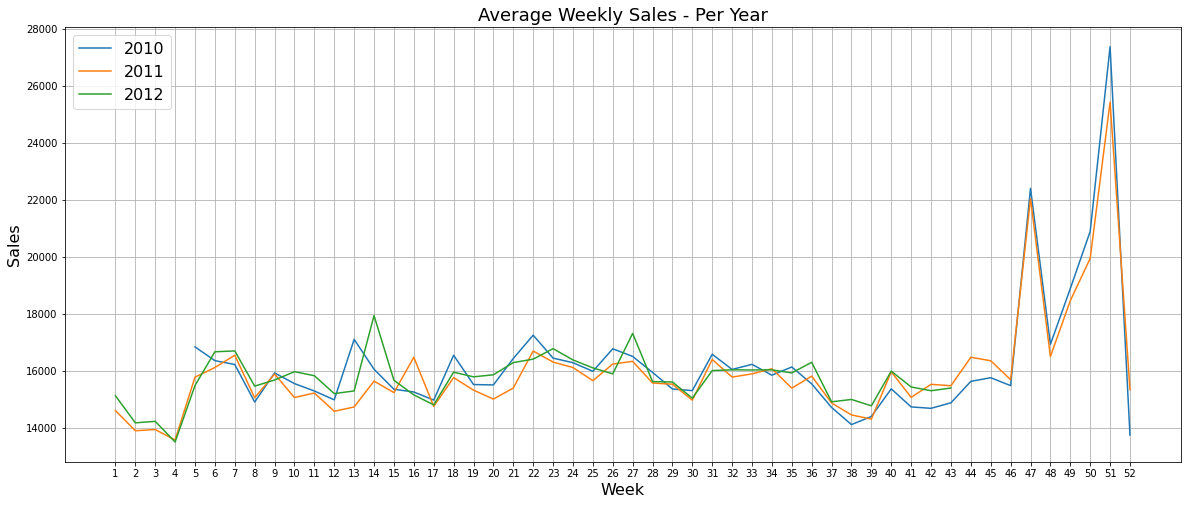

In [15]:
weekly_sales_2010 = train_detail[train_detail.Year==2010]['Weekly_Sales'].groupby(train_detail['Week']).mean()
weekly_sales_2011 = train_detail[train_detail.Year==2011]['Weekly_Sales'].groupby(train_detail['Week']).mean()
weekly_sales_2012 = train_detail[train_detail.Year==2012]['Weekly_Sales'].groupby(train_detail['Week']).mean()
plt.figure(figsize=(20,8))
sns.lineplot(weekly_sales_2010.index, weekly_sales_2010.values)
sns.lineplot(weekly_sales_2011.index, weekly_sales_2011.values)
sns.lineplot(weekly_sales_2012.index, weekly_sales_2012.values)
plt.grid()
plt.xticks(np.arange(1, 53, step=1))
plt.legend(['2010', '2011', '2012'], loc='best', fontsize=16)
plt.title('Average Weekly Sales - Per Year', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Week', fontsize=16)
plt.show()

In [16]:
train_detail.loc[(train_detail.Year==2010) & (train_detail.Week==13), 'IsHoliday'] = True
train_detail.loc[(train_detail.Year==2011) & (train_detail.Week==16), 'IsHoliday'] = True
train_detail.loc[(train_detail.Year==2012) & (train_detail.Week==14), 'IsHoliday'] = True
test_detail.loc[(test_detail.Year==2013) & (test_detail.Week==13), 'IsHoliday'] = True

> The same chart, but showing also the median of the Sales and not divided by Year:

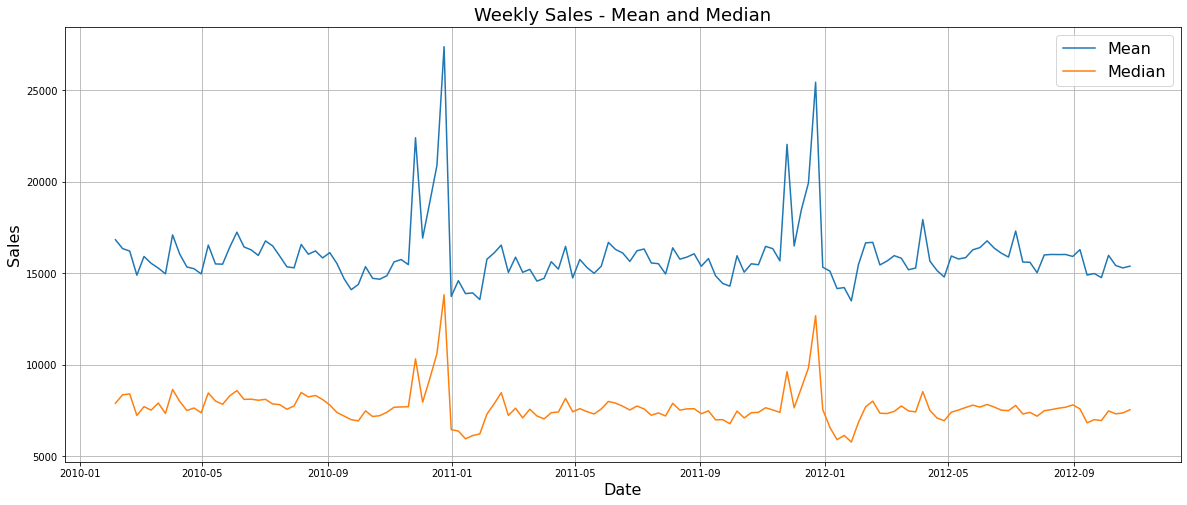

In [17]:
weekly_sales_mean = train_detail['Weekly_Sales'].groupby(train_detail['Date']).mean()
weekly_sales_median = train_detail['Weekly_Sales'].groupby(train_detail['Date']).median()
plt.figure(figsize=(20,8))
sns.lineplot(weekly_sales_mean.index, weekly_sales_mean.values)
sns.lineplot(weekly_sales_median.index, weekly_sales_median.values)
plt.grid()
plt.legend(['Mean', 'Median'], loc='best', fontsize=16)
plt.title('Weekly Sales - Mean and Median', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.show()

### Average Sales per Store and Department

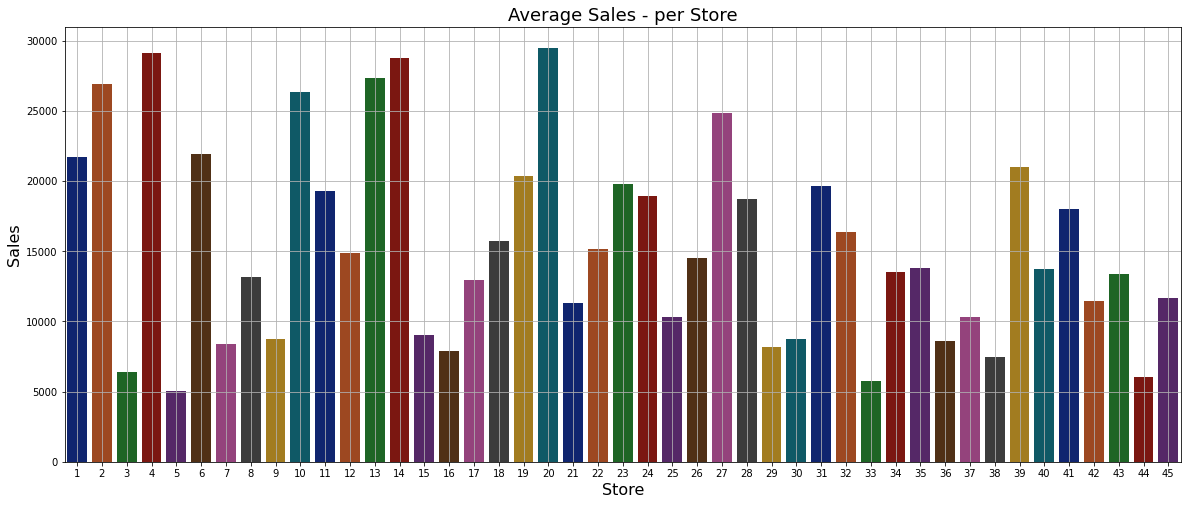

In [18]:
weekly_sales = train_detail['Weekly_Sales'].groupby(train_detail['Store']).mean()
plt.figure(figsize=(20,8))
sns.barplot(weekly_sales.index, weekly_sales.values, palette='dark')
plt.grid()
plt.title('Average Sales - per Store', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Store', fontsize=16)
plt.show()

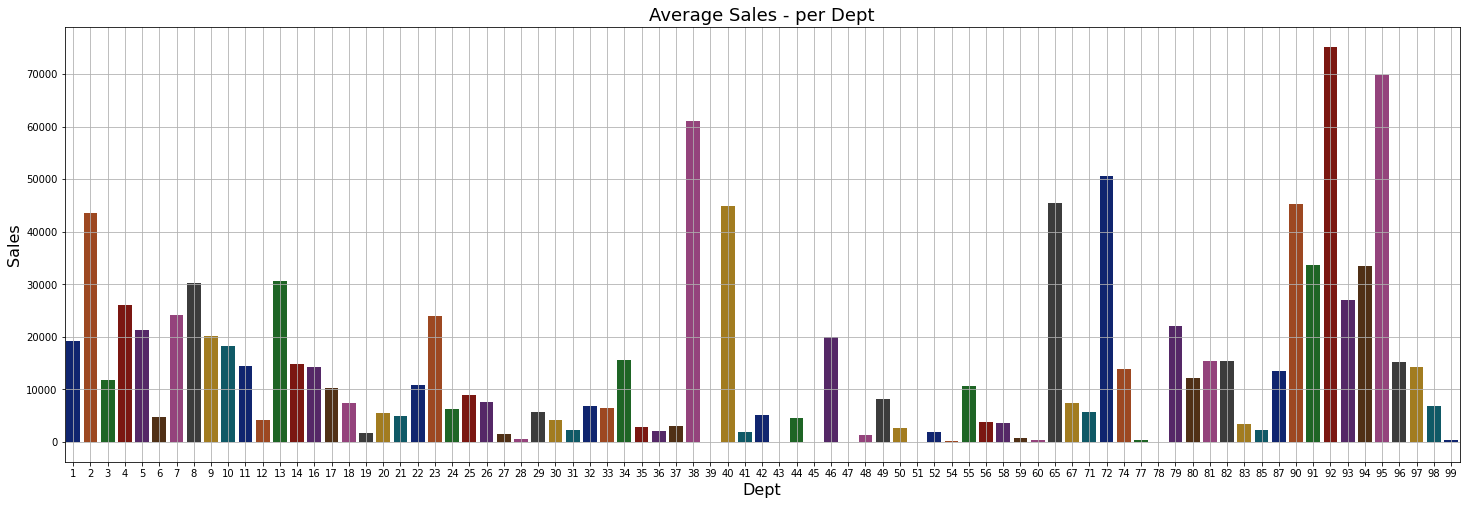

In [19]:
weekly_sales = train_detail['Weekly_Sales'].groupby(train_detail['Dept']).mean()
plt.figure(figsize=(25,8))
sns.barplot(weekly_sales.index, weekly_sales.values, palette='dark')
plt.grid()
plt.title('Average Sales - per Dept', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Dept', fontsize=16)
plt.show()

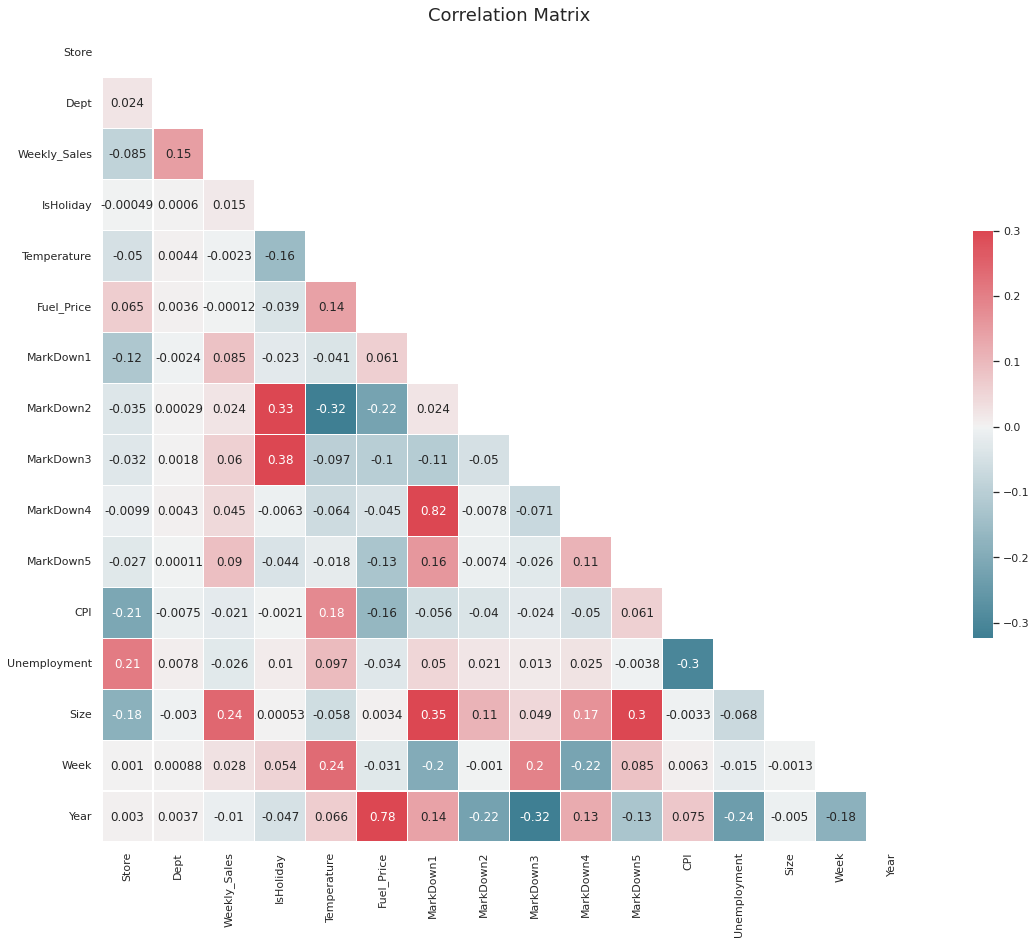

In [20]:
sns.set(style="white")

corr = train_detail.corr()

mask = np.triu(np.ones_like(corr, dtype=np.bool))

f, ax = plt.subplots(figsize=(20, 15))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

plt.title('Correlation Matrix', fontsize=18)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.show()

In [21]:
train_detail = train_detail.drop(columns=['Fuel_Price','MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'])
test_detail = test_detail.drop(columns=['Fuel_Price','MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'])

### Analyzing Variables

In [22]:
def make_discrete_plot(feature):
    fig = plt.figure(figsize=(20,8))
    gs = GridSpec(1,2)
    sns.boxplot(y=train_detail.Weekly_Sales, x=train_detail[feature], ax=fig.add_subplot(gs[0,0]))
    plt.ylabel('Sales', fontsize=16)
    plt.xlabel(feature, fontsize=16)
    sns.stripplot(y=train_detail.Weekly_Sales, x=train_detail[feature], ax=fig.add_subplot(gs[0,1]))
    plt.ylabel('Sales', fontsize=16)
    plt.xlabel(feature, fontsize=16)
    fig.show()

In [23]:
def make_continuous_plot(feature):
    
    fig = plt.figure(figsize=(18,15))
    gs = GridSpec(2,2)
    
    j = sns.scatterplot(y=train_detail['Weekly_Sales'], 
                        x=boxcox1p(train_detail[feature], 0.15), ax=fig.add_subplot(gs[0,1]), palette = 'blue')

    plt.title('BoxCox 0.15\n' + 'Corr: ' + str(np.round(train_detail['Weekly_Sales'].corr(boxcox1p(train_detail[feature], 0.15)),2)) +
              ', Skew: ' + str(np.round(stats.skew(boxcox1p(train_detail[feature], 0.15), nan_policy='omit'),2)))
    
    j = sns.scatterplot(y=train_detail['Weekly_Sales'], 
                        x=boxcox1p(train_detail[feature], 0.25), ax=fig.add_subplot(gs[1,0]), palette = 'blue')

    plt.title('BoxCox 0.25\n' + 'Corr: ' + str(np.round(train_detail['Weekly_Sales'].corr(boxcox1p(train_detail[feature], 0.25)),2)) +
              ', Skew: ' + str(np.round(stats.skew(boxcox1p(train_detail[feature], 0.25), nan_policy='omit'),2)))
    
    j = sns.distplot(train_detail[feature], ax=fig.add_subplot(gs[1,1]), color = 'green')

    plt.title('Distribution\n')
    
    j = sns.scatterplot(y=train_detail['Weekly_Sales'], 
                        x=train_detail[feature], ax=fig.add_subplot(gs[0,0]), color = 'red')

    plt.title('Linear\n' + 'Corr: ' + str(np.round(train_detail['Weekly_Sales'].corr(train_detail[feature]),2)) + ', Skew: ' + 
               str(np.round(stats.skew(train_detail[feature], nan_policy='omit'),2)))
    
    fig.show()

### Weekly_Sales x IsHoliday

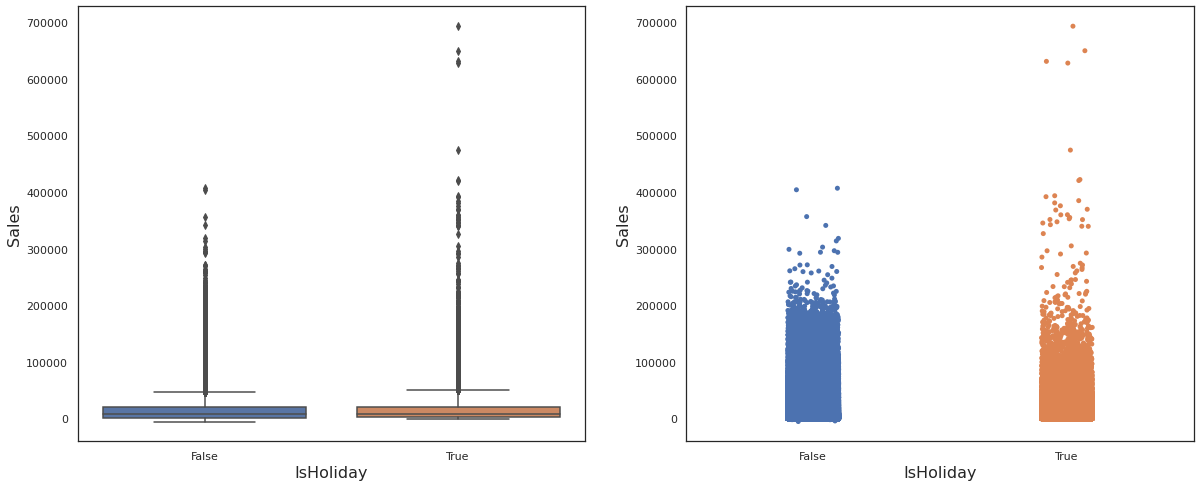

In [24]:
make_discrete_plot('IsHoliday')

### Weekly_Sales x Type

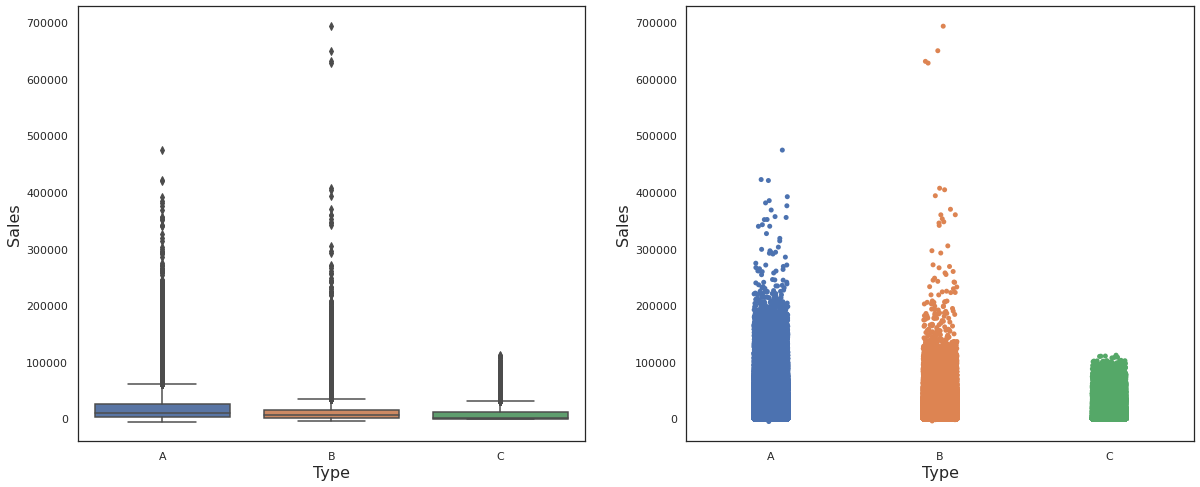

In [25]:
make_discrete_plot('Type')

In [26]:
train_detail.Type = train_detail.Type.apply(lambda x: 3 if x == 'A' else(2 if x == 'B' else 1))
test_detail.Type = test_detail.Type.apply(lambda x: 3 if x == 'A' else(2 if x == 'B' else 1))

### Weekly_Sales x Temperature

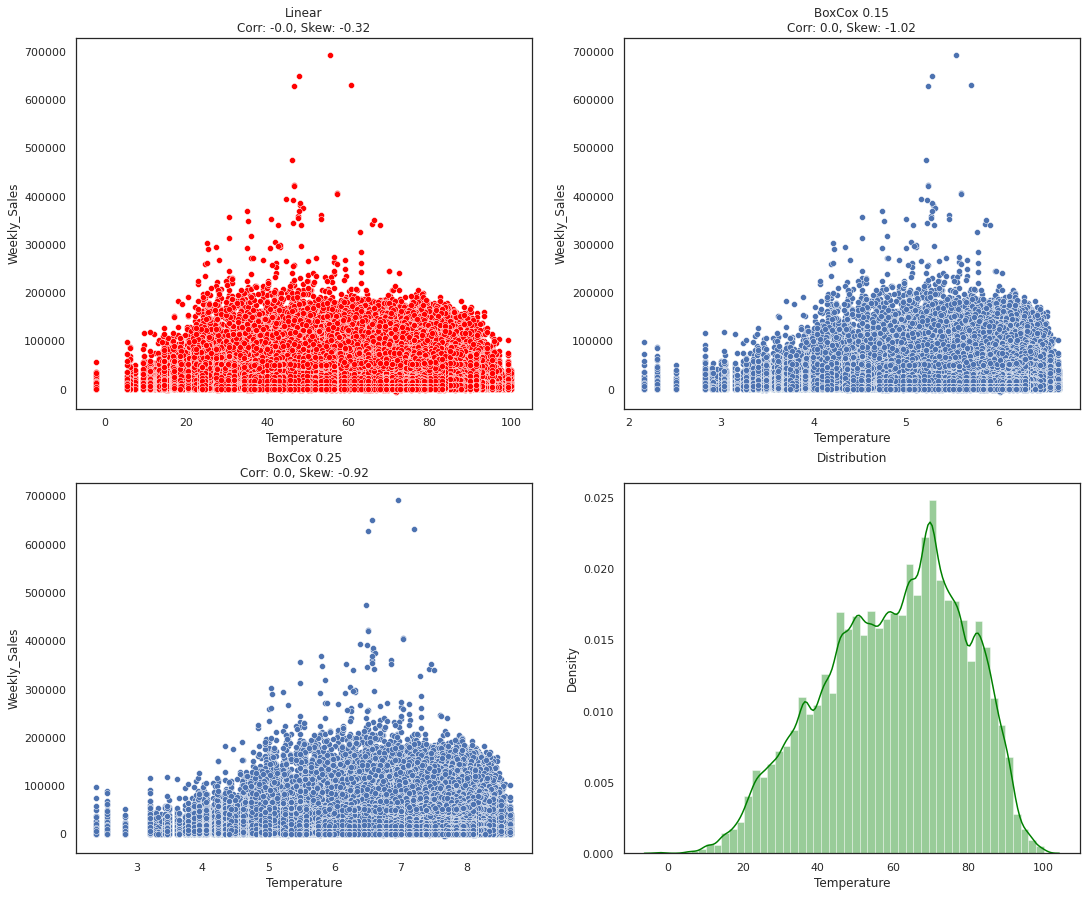

In [27]:
make_continuous_plot('Temperature')

In [28]:
train_detail = train_detail.drop(columns=['Temperature'])
test_detail = test_detail.drop(columns=['Temperature'])

### Weekly_Sales x CPI

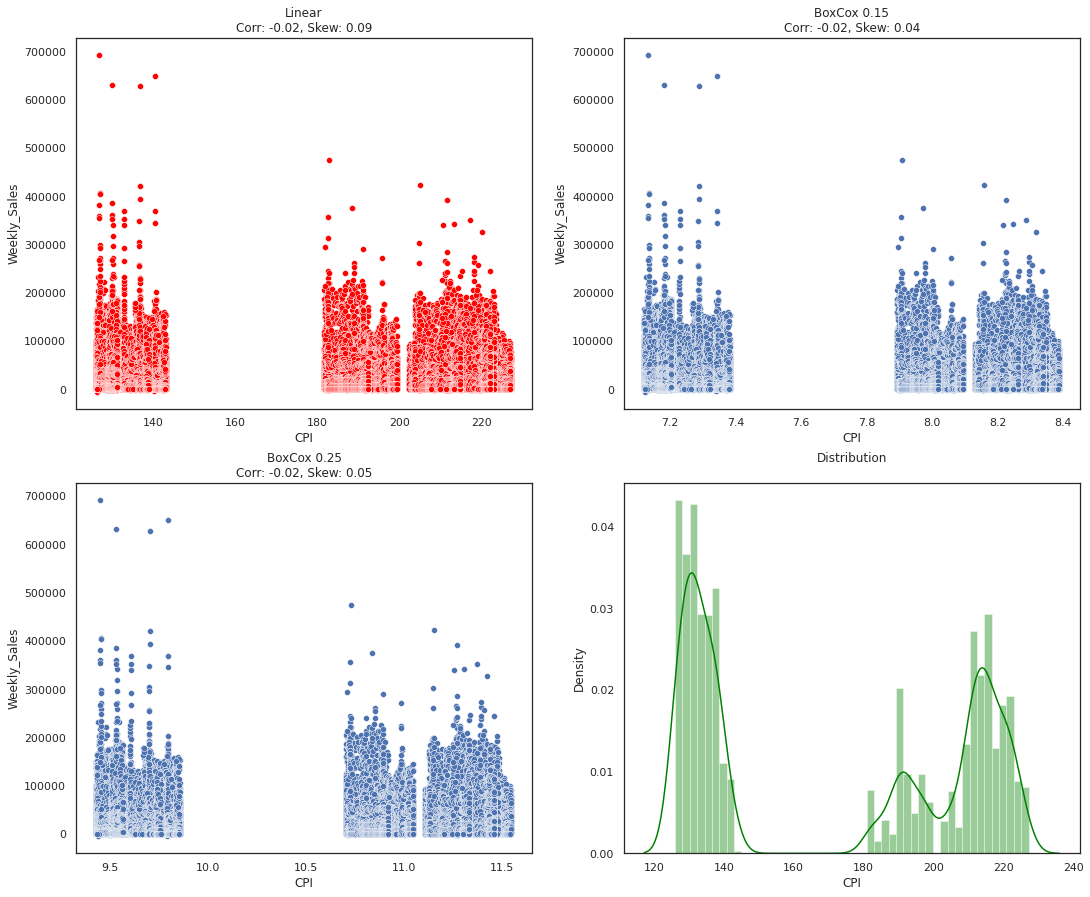

In [29]:
make_continuous_plot('CPI')

> Same for 'CPI'.

In [30]:
train_detail = train_detail.drop(columns=['CPI'])
test_detail = test_detail.drop(columns=['CPI'])

### Weekly_Sales x Unemployment

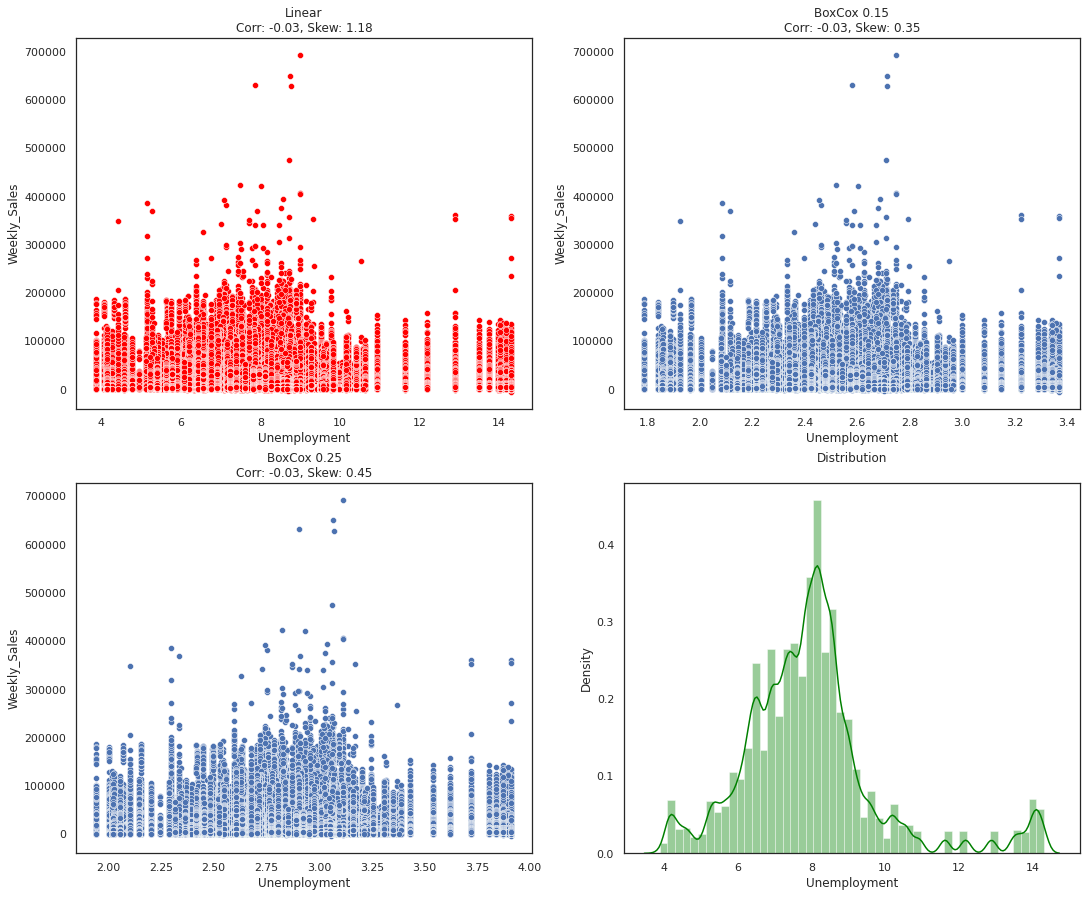

In [31]:
make_continuous_plot('Unemployment')

In [32]:
train_detail = train_detail.drop(columns=['Unemployment'])
test_detail = test_detail.drop(columns=['Unemployment'])

### Weekly_Sales x Size

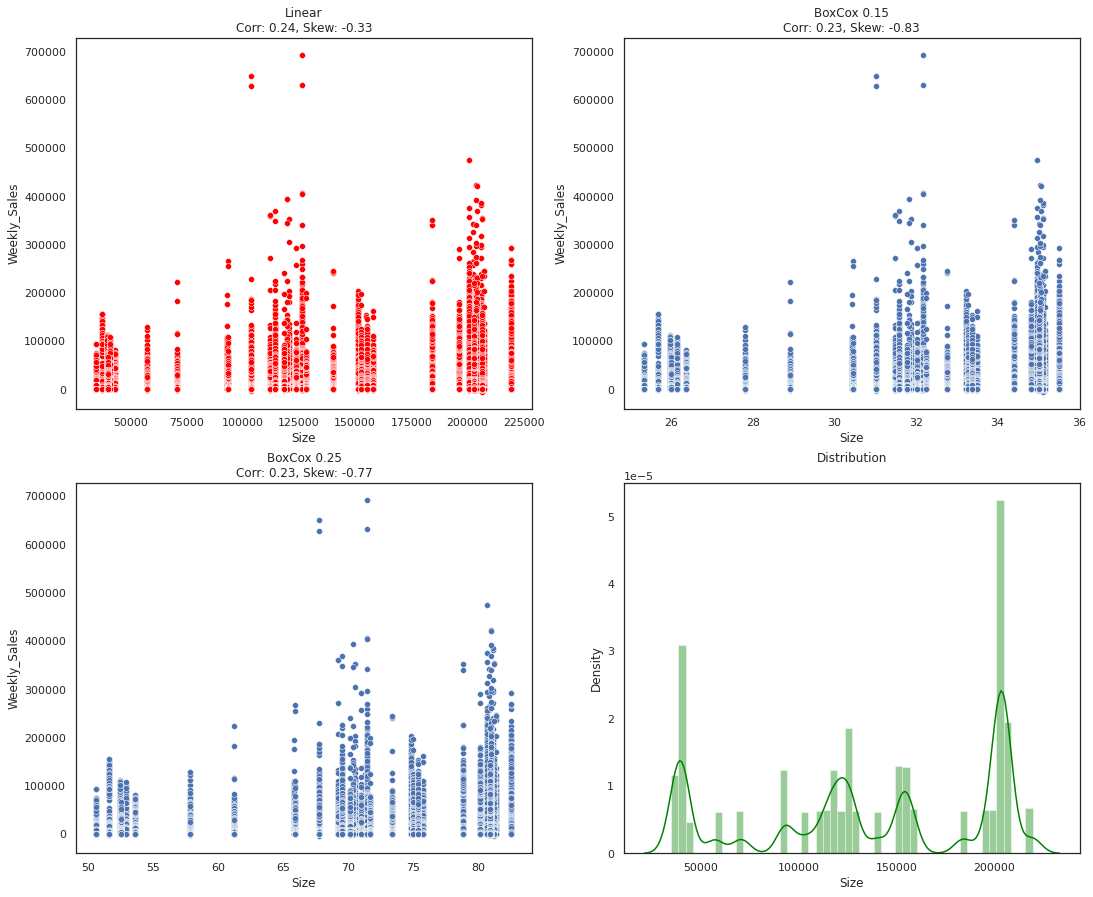

In [33]:
make_continuous_plot('Size')

> And, finally, we will continue with this variable, since it has moderate correlation with 'WeeklySales'.

# 3-Machine Learning

### Model Functions

In [34]:
def WMAE(dataset, real, predicted):
    weights = dataset.IsHoliday.apply(lambda x: 5 if x else 1)
    return np.round(np.sum(weights*abs(real-predicted))/(np.sum(weights)), 2)

In [35]:
def random_forest(n_estimators, max_depth):
    result = []
    for estimator in n_estimators:
        for depth in max_depth:
            wmaes_cv = []
            for i in range(1,5):
                print('k:', i, ', n_estimators:', estimator, ', max_depth:', depth)
                x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.3)
                RF = RandomForestRegressor(n_estimators=estimator, max_depth=depth)
                RF.fit(x_train, y_train)
                predicted = RF.predict(x_test)
                wmaes_cv.append(WMAE(x_test, y_test, predicted))
            print('WMAE:', np.mean(wmaes_cv))
            result.append({'Max_Depth': depth, 'Estimators': estimator, 'WMAE': np.mean(wmaes_cv)})
    return pd.DataFrame(result)

In [36]:
def random_forest_II(n_estimators, max_depth, max_features):
    result = []
    for feature in max_features:
        wmaes_cv = []
        for i in range(1,5):
            print('k:', i, ', max_features:', feature)
            x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.3)
            RF = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, max_features=feature)
            RF.fit(x_train, y_train)
            predicted = RF.predict(x_test)
            wmaes_cv.append(WMAE(x_test, y_test, predicted))
        print('WMAE:', np.mean(wmaes_cv))
        result.append({'Max_Feature': feature, 'WMAE': np.mean(wmaes_cv)})
    return pd.DataFrame(result)

In [37]:
def random_forest_III(n_estimators, max_depth, max_features, min_samples_split, min_samples_leaf):
    result = []
    for split in min_samples_split:
        for leaf in min_samples_leaf:
            wmaes_cv = []
            for i in range(1,5):
                print('k:', i, ', min_samples_split:', split, ', min_samples_leaf:', leaf)
                x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.3)
                RF = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, max_features=max_features, 
                                           min_samples_leaf=leaf, min_samples_split=split)
                RF.fit(x_train, y_train)
                predicted = RF.predict(x_test)
                wmaes_cv.append(WMAE(x_test, y_test, predicted))
            print('WMAE:', np.mean(wmaes_cv))
            result.append({'Min_Samples_Leaf': leaf, 'Min_Samples_Split': split, 'WMAE': np.mean(wmaes_cv)})
    return pd.DataFrame(result)

### Training Model

In [38]:
X_train = train_detail[['Store','Dept','IsHoliday','Size','Week','Type','Year']]
Y_train = train_detail['Weekly_Sales']

In [45]:
X_train

,Store,Dept,IsHoliday,Size,Week,Type,Year
0,1,1,False,151315,5,3,2010
1,1,1,True,151315,6,3,2010
2,1,1,False,151315,7,3,2010
3,1,1,False,151315,8,3,2010
4,1,1,False,151315,9,3,2010
...,...,...,...,...,...,...,...
421565,45,98,False,118221,39,2,2012
421566,45,98,False,118221,40,2,2012
421567,45,98,False,118221,41,2,2012
421568,45,98,False,118221,42,2,2012


In [46]:
Y_train

0         24924.50
1         46039.49
2         41595.55
3         19403.54
4         21827.90
            ...   
421565      508.37
421566      628.10
421567     1061.02
421568      760.01
421569     1076.80
Name: Weekly_Sales, Length: 421570, dtype: float64

In [39]:
RF = RandomForestRegressor(n_estimators=58, max_depth=27, max_features=6, min_samples_split=3, min_samples_leaf=1)
RF.fit(X_train, Y_train)

RandomForestRegressor(max_depth=27, max_features=6, min_samples_split=3,
                      n_estimators=58)

### Predictions

In [40]:
X_test = test_detail[['Store', 'Dept', 'IsHoliday', 'Size', 'Week', 'Type', 'Year']]
predict = RF.predict(X_test)

# 4-Christmas Adjustment

In [41]:
Final = X_test[['Store', 'Dept', 'Week']]
Final['Weekly_Sales'] = predict

In [43]:
predict

array([31020.76414655, 19456.78433046, 19486.06593391, ...,
         702.01590271,   747.64015271,   680.80930788])

In [44]:
Final

,Store,Dept,Week,Weekly_Sales
0,1,1,44,31020.764147
1,1,1,45,19456.784330
2,1,1,46,19486.065934
3,1,1,47,19818.046963
4,1,1,48,24384.413342
...,...,...,...,...
115059,45,98,26,683.274492
115060,45,98,27,679.358285
115061,45,98,28,702.015903
115062,45,98,29,747.640153
